## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


- There were 1965 times of the **old page visits** coming from the **treatment group**.
- There were 1928 times of the **new page visits** coming from the **control group**.

f. Do any of the rows have missing values?

In [8]:
df.isna().any(axis=1).sum()

0

No.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

The solution is to drop them all

In [9]:
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) | \
         ((df.group == 'control')   & (df.landing_page == 'old_page'))]
df2.shape[0]

290585

This number matches the results of the crosstab table: 290585 = 145274 + 145311

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.query("user_id=='773192'")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.loc[df2.user_id.drop_duplicates().index,:]
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2.landing_page == "new_page").mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

The difference is about 0.16%, i.e. the treatment group has 0.16% lower conversion rate than the control group. This number is not large; however, given the large size of both groups, even a very tiny difference can be meaningful. Before we do some formal statistical test, it is hard to draw any conclusion with confidence.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis
$$H_0: p_{new} \leq p_{old}$$
Alternative hypothesis
$$H_1: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query("group == 'treatment'").user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old= df2.query("group == 'control'").user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11881494735393297

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.12104712474358797

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0022321773896550046

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
N = 10000
p_diffs = np.zeros(N)
for i in range(N):
    p_diffs[i] = np.random.binomial(1, p_new, n_new).mean() - np.random.binomial(1, p_old, n_old).mean()

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  1.00000000e+00,   6.00000000e+00,   6.60000000e+01,
          4.53000000e+02,   1.69900000e+03,   3.11300000e+03,
          2.96800000e+03,   1.33000000e+03,   3.28000000e+02,
          3.60000000e+01]),
 array([-0.00609348, -0.00505762, -0.00402176, -0.0029859 , -0.00195003,
        -0.00091417,  0.00012169,  0.00115755,  0.00219342,  0.00322928,
         0.00426514]),
 <a list of 10 Patch objects>)

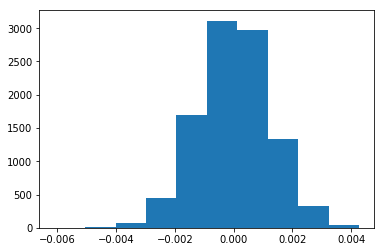

In [27]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
p_diff_actual = df2.query('group == "treatment"').converted.mean() - \
                df2.query('group == "control"').converted.mean()
(p_diffs > p_diff_actual).mean()

0.90620000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**

This number is caled p-value.

We take the null hypothesis as given and try to find out if there exists strong evidence against the null hypothesis. If there was, then we tend to reject the null hypothesis. In our case, the null hypothesis is $p_{new}$ = $p_{old}$ and the alternative hypothesis is $p_{new}$ > $p_{old}$. Thus, if we found in reality $p_{new}$ - $p_{old}$ was large, then this fact would serve as the evidence against the null hypothesis.

To quanfity how strong this evidence is, we can ask the following question:
given $H_0$, in a random world, what is the probabilty that we can get stronger evidence against $H_0$ than the current evidence we have. This is exactly the meaning of p-value. In our case, the p-value is 0.9062. Thus, in a random world, we have 91% chance to get stronger evidence against $H_0$, which means the current evidence (a difference of -0.00158) is very weak. 

A direct implication is that, if we were to reject $H_0$ with the currently observed difference, we would also reject $H_0$ when we encounter larger differences, because they are stronger evidence against $H_0$. Then, in a random world where $H_0$ is true, we have a 91% chance rejecting $H_0$, or equivalently, making type-1 error.

In [29]:
p_diff_actual

-0.0015782389853555567

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'").converted.sum()
convert_new = df2.query("landing_page == 'new_page'").converted.sum()
n_old       = df2.query("landing_page == 'old_page'").user_id.count()
n_new       = df2.query("landing_page == 'new_page'").user_id.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [32]:
count = np.array([convert_old, convert_new])
nobs  = np.array([n_old, n_new])
stat, pval = sm.stats.proportions_ztest(count, nobs, alternative="smaller")

print('Z-score: {0:0.3f}'.format(stat))
print('P-value: {0:0.3f}'.format(pval))

Z-score: 1.311
P-value: 0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The p-value is 0.905 and the z-score is 1.311. They give the same message as in parts **j.** and **k.** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer.** Logistic regression for predicting/explaining binary outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [34]:
df2['ab_page'] = (df2.group == 'treatment').apply(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
X = pd.concat([df2.intercept, df2.ab_page], axis=1)
Y = df2.converted
logit_mod = sm.Logit(Y, X)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
logit_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-03 04:52 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer**

The p-value is now 0.1899. This is a test with $H_0: \beta_{1} = 0$ and $H_1: \beta_{1} \neq 0$. 

Thus, they have completely different meanings. A more negative $\beta_{1}$ will drive down the p-value in this case; however, a more negative difference in Part II will drive up the p-value.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**

Given the dataset we have right now, the only thing we can add is something related to time. Nonetheless, time is definitely an important dimension. For example, we can use time (dummies) to control for seasonality, special promotions, etc. 

One needs to be careful when dealing with time. For example, if there is no linear time trend, then adding a linear time trend would induce bias. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
df_countries = pd.read_csv("countries.csv")
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
df3 = df2.merge(df_countries, left_on='user_id', right_on='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
df3.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64

In [40]:
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [41]:
df4 = pd.get_dummies(df3,columns=['country'])
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country_CA,country_UK,country_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,1


In [42]:
X2 = pd.concat([df4.intercept, df4.ab_page, df4.country_CA, df4.country_UK], axis=1)
Y2 = df4.converted
logit_mod2 = sm.Logit(Y2, X2)
logit_res2 = logit_mod2.fit()
logit_res2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-03 04:52 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
country_CA   -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
country_UK    0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

The coefficients of dummy `country_CA` and `country_UK` are not significant at 5% level. So statistically speaking, people of UK and CA are no different from people of US in terms of conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
df_final = df4.copy()
df_final['ab_page_CA'] = df_final.ab_page * df_final.country_CA
df_final['ab_page_UK'] = df_final.ab_page * df_final.country_UK
df_final.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country_CA,country_UK,country_US,ab_page_CA,ab_page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,1,0,0


In [44]:
X3 = df_final[['intercept', 'ab_page', 'ab_page_CA', 'ab_page_UK']]
Y3 = df_final.converted
logit_mod3 = sm.Logit(Y3, X3)
logit_res3 = logit_mod3.fit()
logit_res3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-03 04:52 AIC:              212778.9383
No. Observations:   290584           BIC:              212821.2568
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0183    0.0126    -1.4486  0.1475  -0.0430   0.0064
ab_page_CA   -0.0644    0.0384    -1.6788  0.0932  -0.1396   0.0108
ab_page_UK    0.0257    0.0188     1.3634  0.1728  -0.0112   0.0625
==================================================================

"""

In [45]:
X4 = df_final[['intercept', 'ab_page', 'country_CA', 'country_UK', 'ab_page_CA', 'ab_page_UK']]
Y4 = df_final.converted
logit_mod4 = sm.Logit(Y4, X4)
logit_res4 = logit_mod4.fit()
logit_res4.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-03 04:52 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
country_CA   -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
country_UK   -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page_CA   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_page_UK    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Since none of the interaction term coefficients are significant, the treatment effects are not statistically different across countries.